<a href="https://colab.research.google.com/github/jhxseng/jhxseng/blob/main/Proyecto_IA_ver_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

# Cargamos el dataset.
df = pd.read_csv('DATASET_SEGURIDAD_CALLAO_FEBRERO2024_0.csv', sep=';')

In [3]:
# Verificamos el tamaño de nuestro dataset.
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.\n")

El dataset tiene 2643 filas y 26 columnas.



In [4]:
# Construimos el dataframe.
data_dict = pd.DataFrame({
    'Columna': df.columns,
    'Tipo de dato': [str(df[col].dtype) for col in df.columns]
})
display(data_dict)

,Columna,Tipo de dato
0,FECHA_CORTE,int64
1,FECHA_REGISTRO,int64
2,ID_DOC_DENUNCIA,object
3,UBIGEO,int64
4,DEPARTAMENTO,object
5,PROVINCIA,object
6,DISTRITO,object
7,TIPO_DE_DENUNCIA,object
8,SITUACION_DENUNCIA,object
9,TIPO,object


In [5]:
# Seleccinamos solo las variables de nuestro interés.
variables = ['SUBTIPO', 'MODALIDAD', 'FECHA_HECHO', 'HORA_HECHO', 'LONGITUD','LATITUD']
df = df[variables]

# Hacemos una impieza básica de los datos
# Eliminamos nulos
df = df.dropna()

# Eliminar las coordenadas inválidas
df = df[df['LONGITUD'] != 0]
df = df[df['LATITUD'] != 0]


In [6]:
# Juntamos las columnas "FECHA_HECHO" y "HORA_HECHO" para convertirlo a formato DATETIME.

df['FECHA_HORA'] = pd.to_datetime(
    df['FECHA_HECHO'].astype(str) + ' ' + df['HORA_HECHO'].astype(str),
    errors='coerce'
)

df = df.dropna(subset=['FECHA_HORA'])

In [7]:
# Ahora filtramos el dataset para centrarnos en el subtipo de datos que estamos buscando analizar.
subtipos_interes = ['HURTO', 'ROBO', 'PELIGRO COMUN']
df_filtrado = df[df['SUBTIPO'].isin(subtipos_interes)].copy()

In [8]:
print(f"El dataset tiene {df_filtrado.shape[0]} filas y {df_filtrado.shape[1]} columnas.\n")

El dataset tiene 751 filas y 7 columnas.



In [9]:
# Ahora enriqueceremos el dataset con data sintética

from sklearn.neighbors import KernelDensity
from scipy.stats import gamma, poisson
from scipy.stats import gaussian_kde

# Función para generar datos sintéticos de coordenadas
def generar_data_coordenadas(df, n_samples = 1000, buffer=0.02):

 min_lat, max_lat = df['LATITUD'].quantile(0.01), df['LATITUD'].quantile(0.99)
 min_lon, max_lon = df['LONGITUD'].quantile(0.01), df['LONGITUD'].quantile(0.99)

 kde = gaussian_kde(df[['LATITUD', 'LONGITUD']].values.T)

# Generación de puntos
 sinte_coords = []
 while len(sinte_coords) < n_samples:
      samples = kde.resample(size=n_samples).T
      mask = (samples[:, 0] >= min_lat - buffer) & (samples[:, 0] <= max_lat + buffer) & \
              (samples[:, 1] >= min_lon - buffer) & (samples[:, 1] <= max_lon + buffer)
      sinte_coords.extend(samples[mask])

 df_sintetico_coords = pd.DataFrame(
      np.array(sinte_coords[:n_samples]),
      columns=['LATITUD', 'LONGITUD']
  )

 return df_sintetico_coords


In [10]:
# Función para generar datos sintéticos de FECHA Y HORA.

def generar_data_tiempo(df, n_samples=1000):
 minutos = df['FECHA_HORA'].dt.hour * 60 + df['FECHA_HORA'].dt.minute

 # Ajustamos la distribución gamma
 a, loc, scale = gamma.fit(minutos, floc=0)
 sinte_minutos = gamma.rvs(a, loc=loc, scale=scale, size=n_samples)

 # Creamos las fechas sintéticas
 fechas = pd.date_range(start=df['FECHA_HORA'].min(), end=df['FECHA_HORA'].max())
 sinte_fechas = np.random.choice(fechas, size = n_samples)

 # Se combina la hora con las fechas sintéticas
 sinte_fechascompletas = pd.to_datetime(sinte_fechas) + pd.to_timedelta(sinte_minutos, unit='m')

 return pd.DataFrame({'FECHA_HORA': sinte_fechascompletas})

In [11]:
# Se combinan los datos sintéticos al dataset.
sinte_coords = generar_data_coordenadas(df_filtrado)
sinte_fechascompletas = generar_data_tiempo(df_filtrado)
sinte_subtipos = np.random.choice(df_filtrado['SUBTIPO'].unique(), size=len(sinte_coords))

df_sintetico = pd.DataFrame({
    'SUBTIPO': sinte_subtipos,
    'MODALIDAD': np.random.choice(df_filtrado['MODALIDAD'].unique(), size=len(sinte_coords)),
    'LATITUD': sinte_coords['LATITUD'],
    'LONGITUD': sinte_coords['LONGITUD'],
    'FECHA_HORA': sinte_fechascompletas['FECHA_HORA']
})

In [12]:
# Se combinan la data real con la sintética

df_final = pd.concat([df_filtrado, df_sintetico], ignore_index = True)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Guardar en una carpeta específica de Drive
df_final.to_csv('/content/drive/MyDrive/mi_dataset.csv', index=False)

Mounted at /content/drive


In [14]:
print(df_final.head())

  SUBTIPO                        MODALIDAD  FECHA_HECHO  HORA_HECHO  \
0    ROBO                    ROBO AGRAVADO   20240223.0      1610.0   
1   HURTO  HURTO AGRAVADO EN CASA HABITADA   20240224.0      1930.0   
2   HURTO                            HURTO   20240213.0       915.0   
3   HURTO                HURTO DE VEHICULO   20240205.0       520.0   
4   HURTO                HURTO DE VEHICULO   20240205.0       520.0   

    LONGITUD    LATITUD          FECHA_HORA  
0 -77.125383 -12.051164 2024-02-23 16:10:00  
1 -77.089799 -12.013531 2024-02-24 19:30:00  
2 -77.126735 -12.051059 2024-02-13 09:15:00  
3 -77.093139 -12.010803 2024-02-05 05:20:00  
4 -77.093139 -12.010803 2024-02-05 05:20:00  


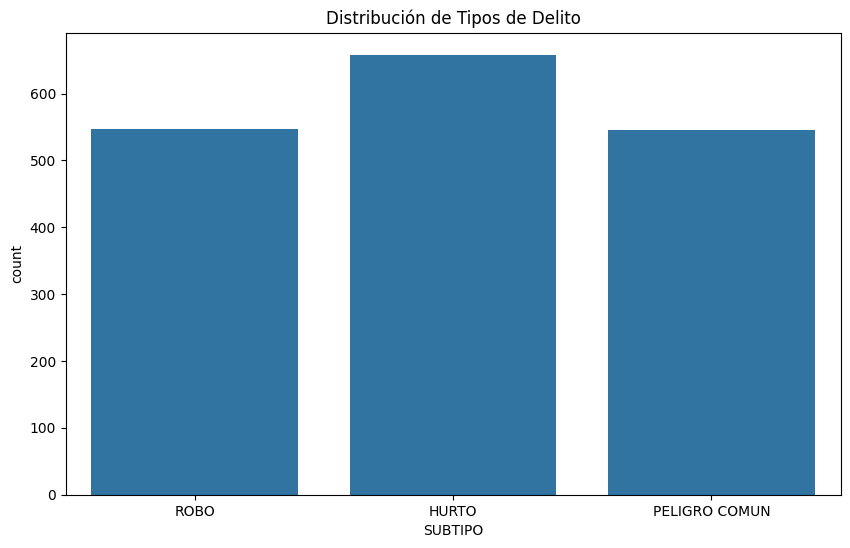

In [ ]:
# Realizamos el análisis exploratorio (EDA) de los datos

import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de subtipos
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='SUBTIPO')
plt.title('Distribución de Tipos de Delito')
plt.show()


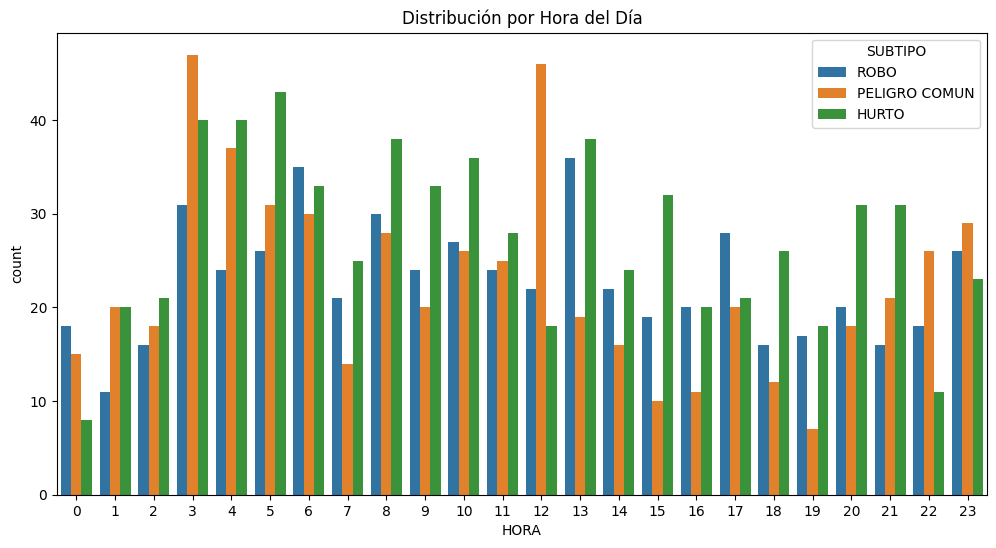

In [ ]:
# Distribución de las horas de los sucesos
df_final['HORA'] = df_final['FECHA_HORA'].dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, x='HORA', hue='SUBTIPO')
plt.title('Distribución por Hora del Día')
plt.show()

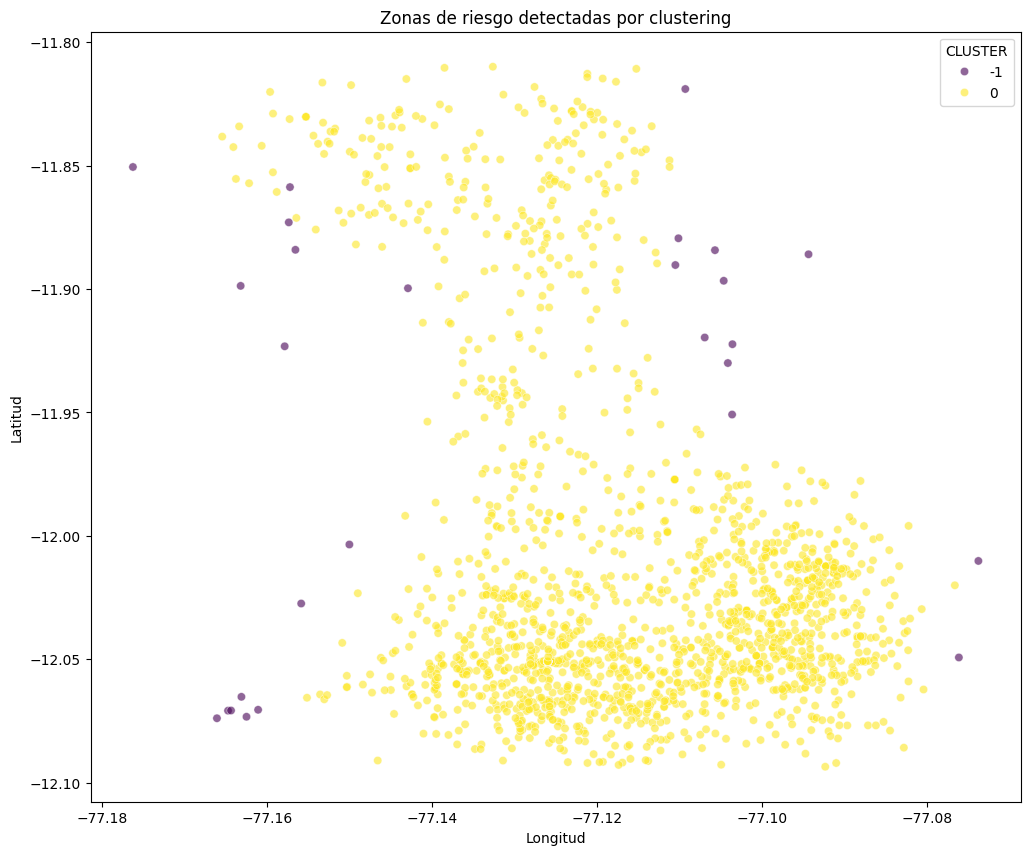

In [ ]:
# Ahora aplicamos clustering para la detección de las zonas con más peligro.
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#Normalizamos los datos

coords = df_final[['LATITUD', 'LONGITUD']].values
coords_scaled = StandardScaler().fit_transform(coords)

#Aplicamos DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters = dbscan.fit_predict(coords_scaled)
df_final['CLUSTER'] = clusters
plt.figure(figsize = (12,10))
sns.scatterplot(data=df_final, x='LONGITUD', y='LATITUD', hue='CLUSTER', palette='viridis', alpha=0.6)
plt.title('Zonas de riesgo detectadas por clustering')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [ ]:
# Identificamos zonas calientes (clusters con más incidentes)

zonas_peligrosas = df_final[df_final['CLUSTER'] != -1].groupby('CLUSTER').size().sort_values(ascending=False)
print("Zonas peligrosas identificadas")
print(zonas_peligrosas.head(5))

Zonas peligrosas identificadas
CLUSTER
0    1724
dtype: int64


**PREPARACIÓN DE LOS DATOS (AVANZADO)**

In [ ]:
from re import X
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Creamos características temporales al dataset
df_final['DIA_SEMANA'] = df_final['FECHA_HORA'].dt.dayofweek
df_final['MES'] = df_final['FECHA_HORA'].dt.month
df_final['HORA_DIA'] = df_final['FECHA_HORA'].dt.hour

#Codificamos las variables categóricas

le = LabelEncoder()
df_final['SUBTIPO_ENCODED'] = le.fit_transform(df_final['SUBTIPO'])
df_final['MODALIDAD_ENCODED'] = le.fit_transform(df_final['MODALIDAD'])

#Creamos nuestra variable objetivo: cluster != -1

df_final['ZONA_PELIGROSA'] = (df_final['CLUSTER'] != -1).astype(int)

#Seleccionar características para el modelo

caract = ['LATITUD', 'LONGITUD', 'DIA_SEMANA', 'MES', 'HORA_DIA', 'SUBTIPO_ENCODED', 'MODALIDAD_ENCODED']
X = df_final[caract]
y = df_final['ZONA_PELIGROSA']

#Dividimos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.98      1.00      0.99       515

    accuracy                           0.98       526
   macro avg       0.99      0.55      0.58       526
weighted avg       0.98      0.98      0.97       526

AUC-ROC: 0.5454545454545454


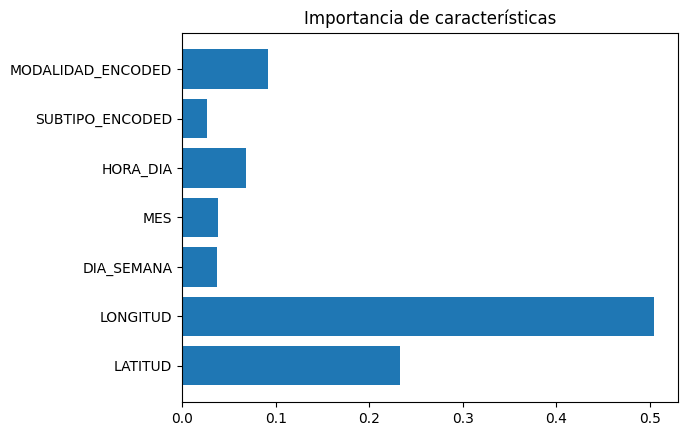

In [ ]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Entrenamos el modelo

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluamos el modelo

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

# Mostramos la importancia de las características

importancias = rf.feature_importances_
plt.barh(caract, importancias)
plt.title('Importancia de características')
plt.show()

In [ ]:
# Visualizamos los resultados

import folium

# Creamos el mapa centrado en el Callao.

mapa = folium.Map(location = [-12.0333, -77.1333], zoom_start=12 )

# Añadimos puntos de incidentes

for idx, row in df_final.iterrows():
  color = 'red' if row['ZONA_PELIGROSA'] == 1 else 'blue'
  folium.CircleMarker(
      location= [row['LATITUD'], row['LONGITUD']],
      radius = 3,
      color = color,
      fill = True,
      fill_opacity=0.6
  ).add_to(mapa)

# Guardamos nuestro mapa

mapa.save("zonas_riesgo_callao.html")